In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Loading and Processing the Wine Quality Dataset

In [43]:
# import dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
data = data.drop(data[(data['total sulfur dioxide']>200)].index) # drops rows at index where condition is met
#data = data[data['total sulfur dioxide']<200] # alternate method, applying mask to dataset to remove outliers

# z-score all columns except quality
selected_columns = data.keys()
selected_columns = selected_columns.drop('quality')

data[selected_columns] = data[selected_columns].apply(stats.zscore)

# binarized results, creating new column of boolean quality
data['bool_quality'] = 0
data['bool_quality'] = np.where(data['quality']>5, 1, 0)

In [44]:
# converting to tensor values
torch_data = torch.Tensor(data[selected_columns].values).float()
labels = torch.Tensor(data['bool_quality'].values).float()

labels = labels.reshape(-1,1)

In [45]:
# splitting / partitioning data into training and test sets
training_data, test_data, training_labels, test_labels = train_test_split(torch_data, labels, test_size=0.1)

# converting to TensorDataset Objects
training_data = TensorDataset(training_data, training_labels)
test_data = TensorDataset(test_data, test_labels)

# creating DataLoaders
batch_size = 32
training_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

# Model Class and Architecture
- #### An attribute will be added so the activation function can be specified.
- As a bonus, I worked on some input validation for specifying the activation function, and added some more helpful error handling.

In [46]:
class ANN_wine(nn.Module):
    def __init__(self, activation_function):
        super().__init__()

        # input layer
        self.input_layer = nn.Linear(11,16) # (11, 16) has some success)

        # hidden layers
        self.batch_norm_1 = nn.BatchNorm1d(16) # batch normalization 1
        self.hidden_layer_1 = nn.Linear(16,64)
        
        self.batch_norm_2 = nn.BatchNorm1d(64) # batch normalization 2
        self.hidden_layer_2 = nn.Linear(64,64)
        
        self.batch_norm_3 = nn.BatchNorm1d(64) # batch normalization 3
        self.hidden_layer_3 = nn.Linear(64,13)
        
        # output layer
        self.output_layer = nn.Linear(13,1)

        # set activation function
        self.activation_func = activation_function

    def forward(self, x):

        # if string name of activation function passed in, gets actual activation function and assigns it
        if isinstance(self.activation_func, str):
            try:
                act_func = getattr(torch, self.activation_func)
            except AttributeError:
                raise ValueError(f"ANN_wine | Error - Invalid activation function '{self.activation_func}' entered!\n"
                                 f"Please enter an activation function from the torch module, check for correct spelling.\n"
                                 f"Examples include: sigmoid, relu, or tanh.\n"
                                 f"Check the torch documentation https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity to find a comprehensive list.\n"
                                 )
        # checks if activation function object was passed in, assigns activation function
        elif hasattr(self.activation_func, '__module__') and self.activation_func.__module__ == 'torch.nn.modules.activation':
            act_func = self.activation_func
        
        # catches any invalid or unexpected input
        else:
            raise TypeError(f"ANN_wine | Error - Unexpected input '{self.activation_func}'.\n"
                            "Enter activation function object (example: torch.nn.ReLU()), or string specifying function name (example: 'sigmoid').")
        
        # input z-score normalized data
        x = F.relu(self.input_layer(x)) 

        # hidden layer 1
        x = self.batch_norm_1(x) # batch normalization
        x = self.hidden_layer_1(x) # hidden layer
        x = act_func(x) # activation function

        # hidden layer 2
        x = self.batch_norm_2(x) # batch norm
        x = self.hidden_layer_2(x) # hidden layer
        x = act_func(x) # activation function

        # hidden layer 3
        x = self.batch_norm_3(x) # batch norm
        x = self.hidden_layer_3(x) # hidden layer
        x = act_func(x) # activation function

        return self.output_layer(x)

In [47]:
# Sanity Check with model
test_data = torch.randn(10,11) # same number of features (columns) as real dataset

test = ANN_wine('sigmoid')
print(f"Test 1 size of output:",test( test_data ).shape)

test_model = torch.nn.Sigmoid()
test2 = ANN_wine(test_model)
print(f"Test 2 size of output:",test2( test_data ).shape)

## testing if value error is raised with unexpected input
#test3 = ANN_wine(4)
#print(f"Test 3 size of output:",test3( test_data ).shape) # uncomment to test if error is raised correctly

Test 1 size of output: torch.Size([10, 1])
Test 2 size of output: torch.Size([10, 1])


In [48]:
# function to create model
def create_ANN_wine_model(learning_rate, activation_function):
    model = ANN_wine(activation_function)

    # loss function
    loss_function = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    return model, loss_function, optimizer

### Training Function

In [49]:
def batch_train_model(number_of_epochs, model, loss_function, optimizer, train_loader, test_loader):
    
    training_accuracy_ary = []
    testing_accuracy_ary = []
    losses_ary = torch.zeros(number_of_epochs)

    for epoch_IDX in range(number_of_epochs):

        model.train()

        batch_accuracy = []
        batch_loss = []
        
        for batch, labels in train_loader:
        # forward pass and calculate loss
            y_hat = model(batch)
            loss = loss_function(y_hat, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate accuracy for current batch
            batch_accuracy.append(100*torch.mean(((y_hat >0) == labels).float()).item())

            # batch losses
            batch_loss.append(loss.item())

        # calculate overall training accuracy and loss
        training_accuracy_ary.append(np.mean(batch_accuracy))
        losses_ary[epoch_IDX] = np.mean(batch_loss)


        model.eval()

        # Cross Validation of Model
        X_data, y_labels = next(iter(test_loader))
        
        with torch.no_grad(): # disables gradient-related computations
            predicted_testing_labels = model(X_data)

        # calculate testing accuracy
        testing_accuracy_ary.append(100*torch.mean(((predicted_testing_labels>0) == y_labels).float()).item())

    return training_accuracy_ary, testing_accuracy_ary, losses_ary

# The Experiment!
- Different instantiations of the model will be created, each with a different activation function used on the hidden layers.
- Overall accuracy from batch training will be recorded and compared to the other models.
- Overall accuracy from the testing will be compared between each model.

In [50]:
# model params
learning_rate = 0.01
num_epochs = 1000

# training params
functions_lst = ['relu', 'tanh', 'sigmoid']
train_accuracy = np.zeros((num_epochs, len(functions_lst)))
test_accuracy = np.zeros((num_epochs, len(functions_lst)))
losses = np.zeros((num_epochs, len(functions_lst)))

for function_IDX, act_function in enumerate(functions_lst):
    # create a model with the activation function
    wine_nn, loss_func, optimizer = create_ANN_wine_model(learning_rate,act_function)

    # training, recording accuracies and losses for each model
    train_accuracy[:,function_IDX], test_accuracy[:, function_IDX], losses[:, function_IDX] = batch_train_model(
        num_epochs,
        wine_nn,
        loss_func,
        optimizer,
        training_loader,
        test_loader
    )

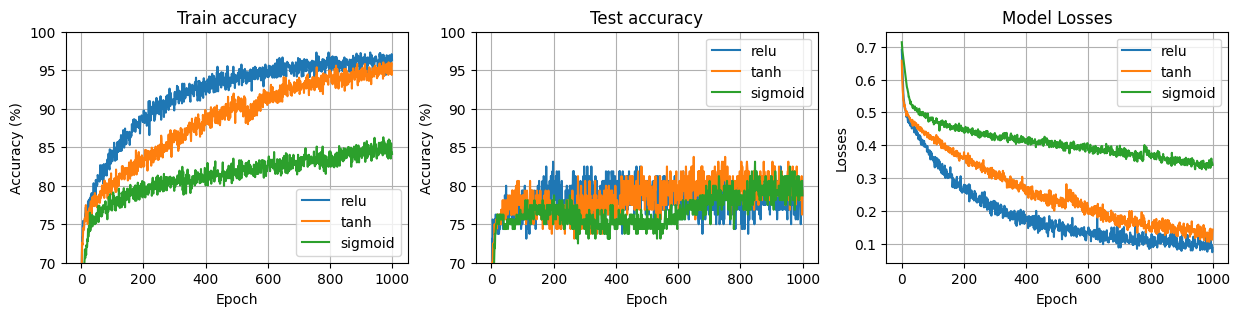

In [51]:
# plot some results
fig,ax = plt.subplots(1,3,figsize=(15,3))
ax[0].plot(train_accuracy)
ax[0].set_title('Train accuracy')
ax[1].plot(test_accuracy)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(functions_lst)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([70,100])
  ax[i].grid()

ax[2].plot(losses)
ax[2].set_title('Model Losses')
ax[2].legend(functions_lst)
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Losses')
ax[2].grid()


plt.show()

#### Quick Look at the Results:
- I was expected that the sigmoid would do the worst with model training. 
    - It seems like the model with the sigmoid activation function also had the worse losses.
    - The losses didn't drop below 30% after 1000 epochs. The other models were both below 20% by that point.

- Amusingly enough, none of the models can get above 80% in testing accuracy. The subjective ratings assigned to wine quality are difficult for the model to learn.

- I'm impressed with how well the ReLU model trained, it actually reached above 90% training accuracy. I wonder why it was able to do that here and not in a previous code challenge...
    - Maybe after several epochs the average approaches 80%.

---
---
# Coding Challenge! 
Lecture 10.92
- #### Comparing ReLU Variants.
- Will compare the ReLU varients found in the `torch.nn` module.
The goal is to see if there is any one of the ReLU variants that out-performs the others for this model and dataset.

In [52]:
# model params
learning_rate = 0.01
num_epochs = 1000

# training params
functions_lst = [torch.nn.ReLU(), torch.nn.ReLU6(), torch.nn.LeakyReLU()]
train_accuracy2 = np.zeros((num_epochs, len(functions_lst)))
test_accuracy2 = np.zeros((num_epochs, len(functions_lst)))
losses2 = np.zeros((num_epochs, len(functions_lst)))

for function_IDX, act_function in enumerate(functions_lst):
    # create a model with the activation function
    wine_nn, loss_func, optimizer = create_ANN_wine_model(learning_rate,act_function)

    # training, recording accuracies and losses for each model
    train_accuracy2[:,function_IDX], test_accuracy2[:, function_IDX], losses2[:, function_IDX] = batch_train_model(
        num_epochs,
        wine_nn,
        loss_func,
        optimizer,
        training_loader,
        test_loader
    )

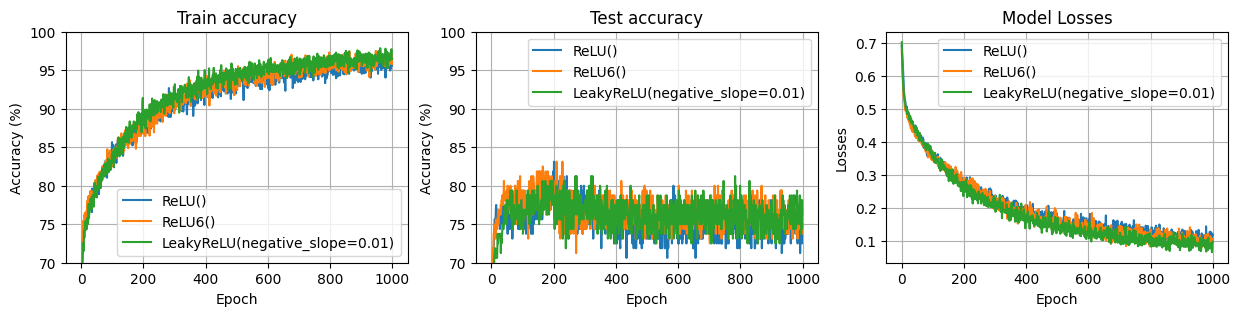

In [53]:
# plot some results
fig,ax = plt.subplots(1,3,figsize=(15,3))

ax[0].plot(train_accuracy2)
ax[0].set_title('Train accuracy')

ax[1].plot(test_accuracy2)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(functions_lst)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([70,100])
  ax[i].grid()

ax[2].plot(losses2)
ax[2].set_title('Model Losses')
ax[2].legend(functions_lst)
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Losses')
ax[2].grid()

plt.show()